In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms

from PIL import Image

%matplotlib inline

# Create Dataset

In [3]:
data_dir = "/content/drive/MyDrive/UNI-AMRITA-SEM2/ComputerVision/FallDatasetProcessed"
batch_size = 32

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), # convert 1 to 3 channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Train dataset and dataloader
train_dataset = datasets.ImageFolder(f'{data_dir}/train', transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_sizes = len(train_dataset)
class_names = train_dataset.classes

# Validation dataset and dataloader
val_dataset = datasets.ImageFolder(f'{data_dir}/val', transform)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

val_sizes = len(val_dataset)

In [5]:
class_names

['fall', 'not_fall']

In [6]:
train_sizes, val_sizes

(3534, 303)

In [7]:
len(train_dataset)

3534

# Create Model

In [8]:
class FDNet(nn.Module):
    def __init__(self, out_features=2):
        super(FDNet, self).__init__()
        mnet = models.efficientnet_b0(pretrained=True)
        for name, param in mnet.named_parameters():
            if("bn" not in name):
                param.requires_grad_(False)
            
        # Parameters of newly constructed modules have requires_grad=True by default
        in_features = mnet.classifier[1].in_features
        mnet.classifier = nn.Sequential(
                                nn.Dropout(p=0.2, inplace=False),
                                nn.Linear(in_features,500),
                                nn.ReLU(),
                                nn.Dropout(),
                                nn.Linear(500, out_features))
        self.mnet = mnet
        
    def forward(self, images):
        features = self.mnet(images)
        
        return features

## FDNet

In [9]:
# Initialize the model.
model = FDNet()

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

FDNet(
  (mnet): EfficientNet(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activation): S

# Train Model

In [10]:
def train(model, optimizer, loss_fn, train_loader, val_loader, start_epoch = 0, epochs=20, device="cpu"):
    model.to(device)
    for epoch in range(start_epoch, start_epoch+epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [11]:
# Initialize the model.
model = FDNet()

# Define the loss function.
criterion = nn.CrossEntropyLoss()

# Define the optimizer.
params = model.mnet.classifier.parameters()
optimizer = optim.SGD(params, lr=0.001, momentum=0.9)

epochs = 20

In [13]:
train(model, optimizer, criterion, train_dataloader, val_dataloader, epochs=epochs, device=device)

Epoch: 0, Training Loss: 0.41, Validation Loss: 0.59, accuracy = 0.63
Epoch: 1, Training Loss: 0.32, Validation Loss: 0.50, accuracy = 0.69
Epoch: 2, Training Loss: 0.25, Validation Loss: 0.41, accuracy = 0.79
Epoch: 3, Training Loss: 0.19, Validation Loss: 0.36, accuracy = 0.83
Epoch: 4, Training Loss: 0.16, Validation Loss: 0.32, accuracy = 0.88
Epoch: 5, Training Loss: 0.13, Validation Loss: 0.30, accuracy = 0.89
Epoch: 6, Training Loss: 0.11, Validation Loss: 0.28, accuracy = 0.90
Epoch: 7, Training Loss: 0.11, Validation Loss: 0.27, accuracy = 0.90
Epoch: 8, Training Loss: 0.09, Validation Loss: 0.27, accuracy = 0.91
Epoch: 9, Training Loss: 0.08, Validation Loss: 0.26, accuracy = 0.91
Epoch: 10, Training Loss: 0.07, Validation Loss: 0.26, accuracy = 0.90
Epoch: 11, Training Loss: 0.07, Validation Loss: 0.25, accuracy = 0.91
Epoch: 12, Training Loss: 0.06, Validation Loss: 0.23, accuracy = 0.90
Epoch: 13, Training Loss: 0.06, Validation Loss: 0.24, accuracy = 0.91
Epoch: 14, Train

In [14]:
os.makedirs(f'{data_dir}/train_model', exist_ok=True)
PATH = f'{data_dir}/train_model/fdnet.pt'
torch.save(model.state_dict(), PATH)

# Evaluation

In [19]:
# Test dataset and dataloader
test_dataset = datasets.ImageFolder(f'{data_dir}/test', transform)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

test_sizes = len(test_dataset)

In [20]:
test_sizes

277

In [21]:
outputs_np = np.empty((0), dtype=int)
targets_np = np.empty((0), dtype=int)

model.eval()
num_correct = 0 
num_examples = 0
for batch in test_dataloader:
    inputs, targets = batch
    inputs = inputs.to(device)
    outputs = model(inputs)
    outputs = torch.max(F.softmax(outputs, dim=1), dim=1)[1]
    targets = targets.to(device)
    correct = torch.eq(outputs, targets).view(-1)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
    
    outputs_np = np.concatenate([outputs_np, outputs.cpu().numpy()], axis=None)
    targets_np = np.concatenate([targets_np, targets.cpu().numpy()], axis=None)

print(f'Accuracy: {num_correct / num_examples:.2f}')
print(num_correct, num_examples)

Accuracy: 0.84
233 277


## Performance Metrics

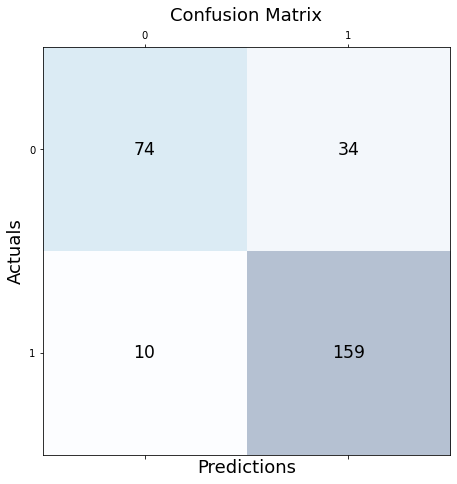

In [22]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(targets_np, outputs_np)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [23]:
from sklearn.metrics import classification_report
print(classification_report(targets_np, outputs_np))

              precision    recall  f1-score   support

           0       0.88      0.69      0.77       108
           1       0.82      0.94      0.88       169

    accuracy                           0.84       277
   macro avg       0.85      0.81      0.82       277
weighted avg       0.85      0.84      0.84       277



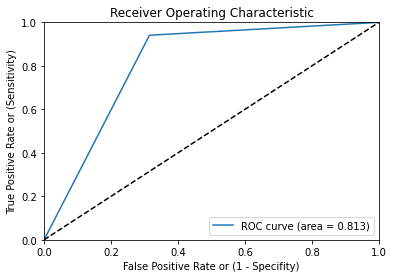

In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(targets_np, outputs_np)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
print('Precision                                   : %.3f'%precision_score(targets_np, outputs_np))
print('Recall                                      : %.3f'%recall_score(targets_np, outputs_np))
print('F1-Score                                    : %.3f'%f1_score(targets_np, outputs_np))

Precision                                   : 0.824
Recall                                      : 0.941
F1-Score                                    : 0.878


In [27]:
from sklearn.metrics import balanced_accuracy_score

print('Balanced Accuracy          : ',balanced_accuracy_score(targets_np, outputs_np))
print('Balanced Accuracy Adjusted : ',balanced_accuracy_score(targets_np, outputs_np, adjusted=True))

Balanced Accuracy          :  0.8130067937760246
Balanced Accuracy Adjusted :  0.6260135875520492


In [31]:
from sklearn.metrics import zero_one_loss

print('Number of Misclassified Examples   : ',zero_one_loss(targets_np, outputs_np, normalize=False))
print('Fraction of Misclassified Examples : ',zero_one_loss(targets_np, outputs_np))

Number of Misclassified Examples   :  44
Fraction of Misclassified Examples :  0.15884476534296033


In [32]:
from sklearn.metrics import fbeta_score

print('Fbeta Favouring Precision : ', fbeta_score(targets_np, outputs_np, beta=0.5))
print('Fbeta Favouring Recall    : ' ,fbeta_score(targets_np, outputs_np, beta=2.0))

Fbeta Favouring Precision :  0.8448459086078641
Fbeta Favouring Recall    :  0.9148446490218644
